# Assignment 3a
### Task 2: Collaborative Filtering
**Abrar Sultan Hud - a1935666**

In [1]:
# library
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

warnings.filterwarnings('ignore')

### Loading Data

In [2]:
# loading the data
data = pd.read_csv('Groceries data train.csv')

# overview of the dataset
data.head()

,Member_number,Date,itemDescription,year,month,day,day_of_week
0,3021,30/01/2015,frankfurter,2015,1,30,4
1,1292,24/10/2015,pork,2015,10,24,5
2,4206,4/04/2014,root vegetables,2014,4,4,4
3,4369,25/08/2015,onions,2015,8,25,1
4,1522,1/07/2014,waffles,2014,7,1,1


### Data Analysis and Visualization

In [3]:
# getting general infomation about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27000 entries, 0 to 26999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    27000 non-null  int64 
 1   Date             27000 non-null  object
 2   itemDescription  27000 non-null  object
 3   year             27000 non-null  int64 
 4   month            27000 non-null  int64 
 5   day              27000 non-null  int64 
 6   day_of_week      27000 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.4+ MB


In [4]:
# number of users in the dataset
print(f'number of available users: {data['Member_number'].nunique()}')

# number of items in the dataset
print(f'number of available items: {data['itemDescription'].nunique()}')

# number of year
print(f'number of years of data: {data['year'].nunique()}')

number of available users: 3872
number of available items: 167
number of years of data: 2


**Interpretation** <br>
From the above information we can see that, this dataset has $27000$ entries for users (members) purchase histroy. Initial inspection, tell us that the dataset has no missing values. Again we can see that, there are $3872$ users in the dataset and $167$ unique items. Furthermore, this dataset contains two years of members purchase history.

In [5]:
# getting item frequency to find out most popular items
item_frequency = data['itemDescription'].value_counts()
item_frequency

itemDescription
whole milk               1709
other vegetables         1320
rolls/buns               1197
soda                     1060
yogurt                    928
                         ... 
bags                        3
rubbing alcohol             3
frozen chicken              2
preservation products       1
kitchen utensil             1
Name: count, Length: 167, dtype: int64

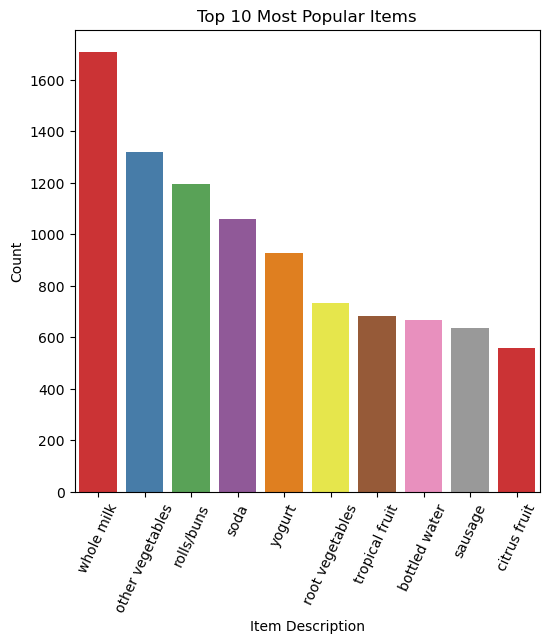

In [6]:
# plotting a barchart using above information to show
# the top ten most popular items
plt.figure(figsize=(6,6))
sns.barplot(x=item_frequency.index[:10], y=item_frequency.values[:10], palette='Set1')
plt.title('Top 10 Most Popular Items')
plt.xlabel('Item Description')
plt.ylabel('Count')
plt.xticks(rotation=65)
plt.show()

**Interpretation** <br>
From the above bar plot we can see the top 10 frequent items in the dataset purchased by member. Where whole milk is the most purchased item. This bar plot give us an idea about the most commonly bought items from the grocery store.

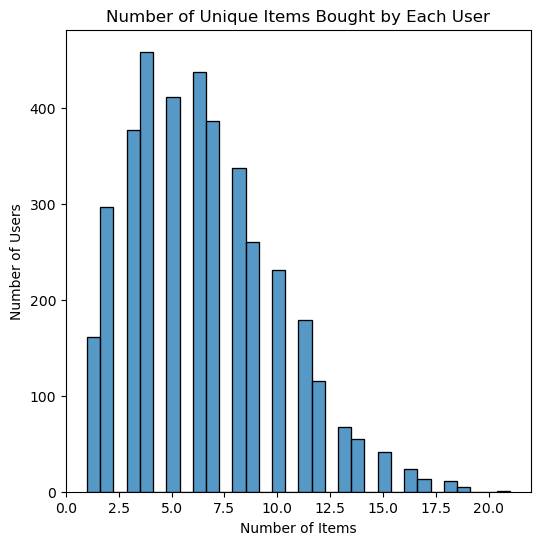

In [7]:
# number of unique items bought by each user
items_per_user = data.groupby('Member_number')['itemDescription'].nunique()
plt.figure(figsize=(6,6))
sns.histplot(items_per_user, palette='Set1')
plt.title("Number of Unique Items Bought by Each User")
plt.xlabel("Number of Items")
plt.ylabel("Number of Users")
plt.show()

**Interpretation** <br>
The above histogram shows the number of unique items a user bought. From the plot we can see that most of the users bought 3 to 9 unique items in their purchase history. This plot is little bit right skewed meaning that, most of the member does not buy wide range of items so they have a common buying pattern. This indicates that our utility matrix will be very sparse.

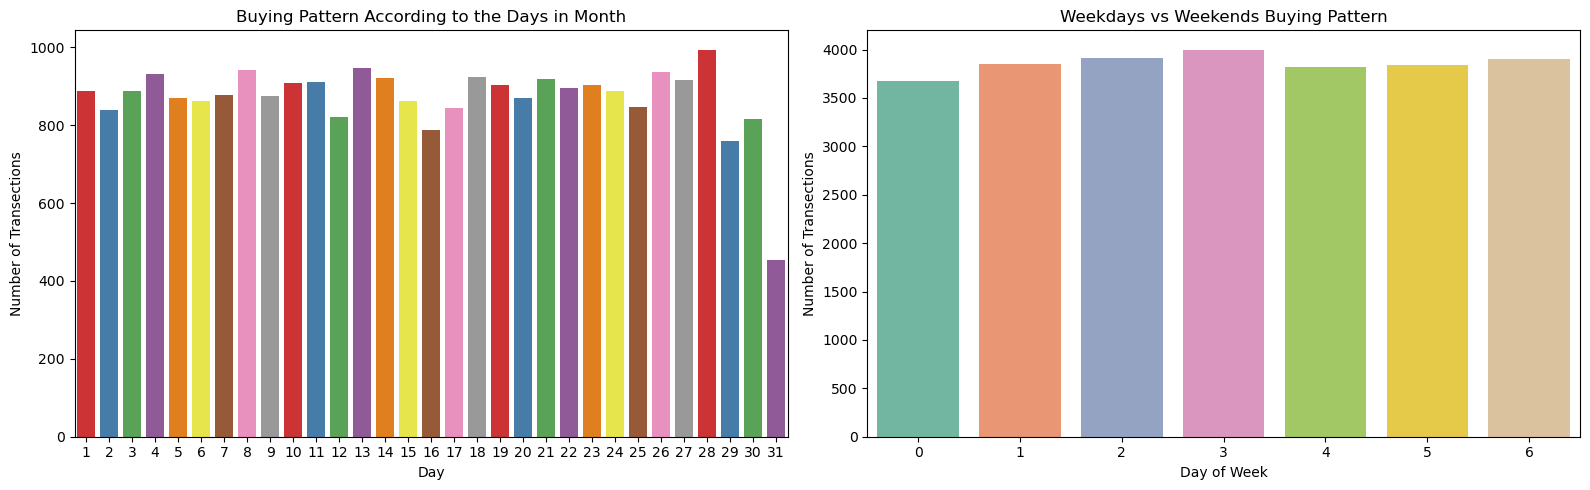

In [8]:
# buying pattern
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# buying pattern according to days in month
daily_buying_count = data['day'].value_counts()
sns.barplot(x=daily_buying_count.index, y=daily_buying_count.values, ax=axes[0], palette='Set1')
axes[0].set_title("Buying Pattern According to the Days in Month")
axes[0].set_xlabel("Day")
axes[0].set_ylabel("Number of Transections")


# buying pattern according days in week (weekdays vs weekends buying pattern)
weekday_weekend_buying_count = data['day_of_week'].value_counts()
sns.barplot(x=weekday_weekend_buying_count.index, y=weekday_weekend_buying_count.values, ax=axes[1], palette='Set2')
axes[1].set_title("Weekdays vs Weekends Buying Pattern")
axes[1].set_xlabel("Day of Week")
axes[1].set_ylabel("Number of Transections")

plt.tight_layout()
plt.show()

**Interpretation** <br>
From the left bar plot we can see that, member's tend to shop during the start or end of the month. Where the end of the month shopping is bit higher than the starting of the month. 

Again, from the right plot we can see member's tend to shop during the middle of the week or at the end of the week. Shopping frequency at the begining of the week is a bit lower.

In [9]:
# getting months and year (as we have two years of data)
data['Date'] = pd.to_datetime(data['Date'])
data['year_n_month'] = data['Date'].dt.to_period('M')

# getting item frequency per month (reference 1)
monthly_item_frequency = data.groupby(['year_n_month', 'itemDescription']).size().reset_index(name='Counts') 

# sorting the values to get top five items bought per month
monthly_item_frequency_sorted = monthly_item_frequency.sort_values(['Counts'], ascending=False).groupby('year_n_month')

# top five items bought per month
top_five_item = monthly_item_frequency_sorted.head(5)

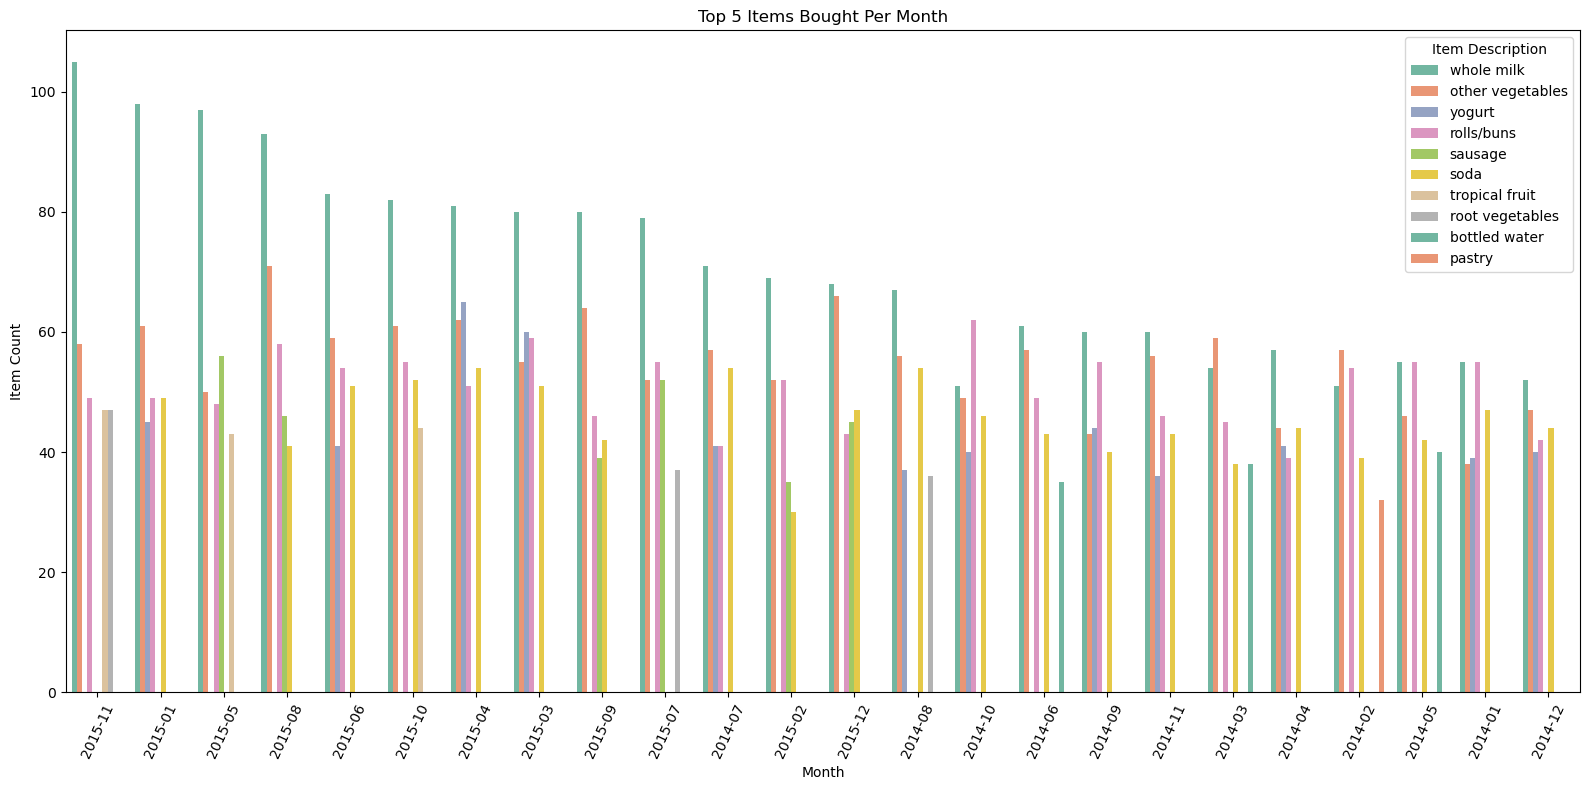

In [10]:
# ploting using above information
plt.figure(figsize=(16, 8))
sns.barplot(x=top_five_item['year_n_month'], y=top_five_item['Counts'], hue=top_five_item['itemDescription'], palette='Set2')
plt.title('Top 5 Items Bought Per Month')
plt.ylabel("Item Count")
plt.xlabel("Month")
plt.legend(title='Item Description')
plt.xticks(rotation=65)

plt.tight_layout()
plt.show()


**Interpretation** <br>
From the above plot we can see the top 5 most frequent item bought each month. Here, in every month "whole milk" is the most frequent item. Then there is "other vegetables" and so on. A colser look at this plot confirms that, the monthly frequently bought items align with our earlier top 10 most frequent items.

### Collaborative Filtering Implementation

Here we have implemented the collaborative filtering algorithm. Steps of this Algorithm is as follows:
1. Create an utility matrix, each row is an member and each column is item
2. Then calculate prediction score that an given user will by an item. So, here for each item that a given user has not bought a predition score will be calculated to socre the possibily of recommendin that item. (formula showed in the function comment)
3. Recommend top K items with the highest prediction score. 
4. This system also takes frequent patterns as input mined from pattern mining algorithm (task 1) and output top k recommended items.    

In [11]:
class CollaborativeFiltering:
    '''
    Here, we have implemented a user-based collaborative filtering as well as
    pattern based recommendation system.

    Input:
      - Raw Data (CSV)
      - Pattern Data (output of task 1 - CSV)

    Output: 
    - List of Top K recommended items for a member (member_number) for either collaborative filtering (raw data) or patterns (pattern data)
   
    '''
    def __init__(self, data):
        '''
        here, we are loading the raw CSV data and preprocessing it. 
        '''
        self.data = pd.read_csv(data)
        self.data_processing()
    
    def data_processing(self):
        '''
        here, we are creating a utility matrix where is each row is a user (member) and each column is an item
        this is to calculate similarity between users (members).

        '''
        # adding a count column to count the each items bought by a user (member)
        # as our raw dataset contains user id (member bumber) and one item in each row, so initially I am adding 1 to count column
        self.data['count'] = 1

        # creating a utility matrix (basically we are creating a wide form of the dataset)
        # where all the colums are available unique item name (167 items) and rows are the member's ID (3872 members) and 
        # values are the values from count column (summed for a item bought multiple times)
        self.utility_matrix = pd.pivot_table(self.data, index='Member_number', columns='itemDescription', values='count', aggfunc='sum', fill_value=0)

        # coverting the utility matrix (dataframe) to numpy for faster and efficient system
        self.utility_matrix_numpy = self.utility_matrix.to_numpy()

        # mapping member ID's to numpy arrary index
        self.member_id_to_np_index_map = {}
        for i, member_id in enumerate(self.utility_matrix.index):
            self.member_id_to_np_index_map[member_id] = i

        # mapping item decription to numpy index
        self.item_description = self.utility_matrix.columns.to_list()

        # overview of the utility matrix
        return self.utility_matrix
    
   
    def cosine_similarity(self, user_1, user_2):
        '''
        calculating cosine similarity between two users
        '''
        # calculating dot product between two users
        dot_product = np.dot(user_1, user_2)

        # calculating magnitude 
        magnitude_of_vector = np.sqrt(np.sum(user_1 ** 2) * np.sum(user_2 ** 2))

        # cosine similarity
        cos_similarity = dot_product / magnitude_of_vector
        return cos_similarity
    
    def predict_purchase(self, item_index, member_index):
        '''
        here, we are calculating the predition score that indicates the score that a given user will buy a specific item.
        
        This score is the weighted avegrage calculated by using the formula, 

                           similarity(given_user, all_user_who_bought_the_item) * purchase_frequency_of_all_user_who_bought_the_item
        weighted_avg = ------------------------------------------------------------------------------------------------------------------ (division)
                                       sum(similarity(given_user, all_user_who_bought_the_item)) 
      
        '''
        # getting the item column 
        items_each_member = self.utility_matrix_numpy[:, item_index]

        # getting the index of the members who bought this item
        purchesed_item_indeces = np.where(items_each_member != 0)[0]

        # getting the purchase frequency of the members who bought the item
        purchesed_item_count = items_each_member[purchesed_item_indeces]

        # calculating the similarity between the given member and the member who bought the item
        member_similarity = [self.cosine_similarity(self.utility_matrix_numpy[member_index], self.utility_matrix_numpy[i]) for i in purchesed_item_indeces]
        
        # calculating the prediction score (weighted avegrage)
        weighted_avg = np.dot(member_similarity, purchesed_item_count) / np.sum(member_similarity) 
        return weighted_avg

    
    def make_recommendation(self, member_number, recommend_top_k):
        '''
        here, we are making recommending top K items to the member. For this we find the items that user did not 
        bought and then get the prediction score (using predict_purchase method) for those items and select the top K item
        as recommended item.

        '''
        # if member not available in the training data (new member) we will be recommending most 
        # frequent items in the training data
        if member_number not in self.member_id_to_np_index_map:
            return self.cold_start(recommend_top_k)

        # getting index for member id
        member_index = self.member_id_to_np_index_map[member_number]
        
        # getting the item index that the member have not bought
        item_not_bought_by_member_indeces = np.where(self.utility_matrix_numpy[member_index] == 0)[0]

        weighted_scores = []
        for item_index in item_not_bought_by_member_indeces:
            # getting the prediction score for each item
            predicted_purchase_score = self.predict_purchase(item_index, member_index)
            weighted_scores.append((item_index, predicted_purchase_score))

        # sorting based on prediction scores and selecting the top K items
        top_items_to_recommend = sorted(weighted_scores, key=lambda x: x[1], reverse=True)[:recommend_top_k]

        #  getting the item description
        recommened_items = [self.item_description[i] for i, weight in top_items_to_recommend]
        return recommened_items
    

    def make_recommendation_from_pattern(self, patterns, member_number, recommend_top_k):
        '''
        here, we are making item recommendation based on the frequent pattern for a given user.

        For this method, first we indentify all  the items that the user bought. Then we loop through all the frequent patterns (rules), and make recommendation 
        if the antecedent is a subset of the user's already bought items. Here, the items in (consequent - item_bought_by_user) items not bought 
        for the related antecedent is choosen for recommandation. For making recommendation we select top K items based on their lift score.
        '''
        # loading the pattern data
        self.patterns = pd.read_csv(patterns)

        # getting the items for the give user
        user_item_list = self.utility_matrix.loc[member_number]

        # getting the items user already bought
        item_bought_by_user = user_item_list[user_item_list != 0].index.tolist()

        # converting the list to frozentset for comparison
        item_bought_by_user = frozenset(item_bought_by_user)

        recommended_item = []
        for row_index, row in self.patterns.iterrows():
            temp_dict = {}

            # getting the antecedent and consequent of a rule 
            antecedent = self.str_to_frozenset(row['antecedents'])
            consequent = self.str_to_frozenset(row['consequents'])

            # getting the metric values 
            lift = row['lift']
            support = row['support']
            confidence = row['confidence']

            # making recommendation 
            if antecedent.issubset(item_bought_by_user):
                # getting the items that user has not bought
                item_not_bought =  consequent - item_bought_by_user
                for item in item_not_bought:
                    temp_dict['item'] = item
                    temp_dict['lift'] = lift
                    temp_dict['support'] = support
                    temp_dict['confidence'] = confidence
                    recommended_item.append(temp_dict)

        # sorting the items base on lift score, to recommend the top K items
        recommended_item.sort(key=lambda x: x['lift'], reverse=True)

        # filtering out the duplicate items
        unique_item = []
        for item in recommended_item:
            if item['item'] in unique_item:
                continue
            unique_item.append(item['item'])
        
        # return K or less that K items
        if len(unique_item) < recommend_top_k:
            return unique_item
        else:
            return unique_item[:recommend_top_k]
    
    def cold_start(self, recommend_top_k):
        '''
        make recommendation for users not in the training data (new users). Here we will recommend the top K most frequent item
        in the training set for the new member.
        '''
        # getting item frequency
        item_count = self.data['itemDescription'].value_counts()
        
        # getting top K item description for recommendation
        frequent_item = item_count.index.to_list()[:recommend_top_k]
        return frequent_item

    def str_to_frozenset(self, str):
        '''
        convert string to frozenset for pattern data
        '''
        # removing getting the itemset inside frozenset() string
        items_str = str[len("frozenset("):-1]

        # parses the string literal to set
        item_set = literal_eval(items_str)

        # converting the set to frozen set and return 
        return frozenset(item_set)
    

In [27]:
# instantiating class
recommend_system = CollaborativeFiltering(data=data)

# overview of the utility matrix
recommend_system.data_processing()

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Member_number,,,,,,,,,,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1001,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,2,0,0
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


From the above output we can see that, the utility matrix is very sparse.

In [ ]:
# making recommendation for a user (from raw data)
data = 'Groceries data train.csv'
member_number = 1000
recommend_item = 5

# making recommendation
recommend_system.make_recommendation(member_number, recommend_item)

['whole milk',
 'other vegetables',
 'rolls/buns',
 'root vegetables',
 'tropical fruit']

In [13]:
# making recommendation for a user (from pattern)
pattern = 'rules.csv'
member_number = 1000
recommend_item = 5

# instantiating class
recommend_system = CollaborativeFiltering(data=data)

# making recommendation
recommend_system.make_recommendation_from_pattern(pattern, member_number, recommend_item)

['whole milk', 'rolls/buns', 'other vegetables']

#### Evaluate Perfomance

We choose precision at K and Recall at K as our evaluation metric. 

**Precision at K:** It measures the proportion of the actual items among the top K recommended item [2]. As we are recommeding top K items and we have ground truth or relavent item data in the test set, this metric is a good choice for measuring performance of our recommender system. Formula: 
$$\text{precision at K} = \frac{\text{number of relavent items in top K recommendation}}{K}$$


**Recall at K**: It measure the proportion of out of all the actual items (relavent items) how many is in the recommended item [2].Formula:
$$\text{recall at K} = \frac{\text{number of relavent items in top K recommendation}}{\text{number of relavent items}}$$

In [18]:
# loading test data
test_data = pd.read_csv('Groceries data test.csv')
test_data.head()

,Member_number,Date,itemDescription,year,month,day,day_of_week
0,3481,8/03/2015,candy,2015,3,8,6
1,1254,19/04/2015,white wine,2015,4,19,6
2,2835,28/01/2014,domestic eggs,2014,1,28,1
3,2854,2/08/2015,coffee,2015,8,2,6
4,4637,12/08/2014,bottled water,2014,8,12,1


In [15]:
# getting the member id's from the test data
test_member_id = test_data['Member_number'].to_list()
test_member_id.sort()
test_member_id = set(test_member_id)
print(f'Member in the test data: {len(test_member_id)}')

Member in the test data: 3566


In [24]:
def precision_at_k(recommended, ground_truth, k):
    '''
    calculating precision at K 
    '''
    # getting the recommened items (k items)
    recommended = recommended
    
    # number of relavent items (common in both)
    relavent_item_at_k = len(set(recommended).intersection(ground_truth))
    return relavent_item_at_k / k

def recall_at_k(recommended, ground_truth):
    '''
    calculating recall at K 
    '''
    # getting the recommened items (k items)
    recommended = recommended
    
    # number of relavent items (common in both)
    relavent_item_at_k = len(set(recommended).intersection(ground_truth))
    return relavent_item_at_k / len(ground_truth)

In [ ]:
# evaluating (precision score)
precision_score_list = []
for member_id in list(test_member_id):
    true_items = test_data[test_data['Member_number'] == member_id]['itemDescription'].to_list()
    recommended_items_for_user = recommend_system.make_recommendation(member_id, 5)
    precision_score = precision_at_k(recommended_items_for_user, true_items, 5)
    precision_score_list.append(precision_score)

print(f'Mean Precision Score: {np.mean(precision_score_list):.4f}')

Mean Precision Score: 0.0864


In [25]:
# evaluating (recall score)
recall_score_list = []
for member_id in test_member_id:
    true_items = test_data[test_data['Member_number'] == member_id]['itemDescription'].to_list()
    recommended_items_for_user = recommend_system.make_recommendation(member_id, 5)
    recall_score = recall_at_k(recommended_items_for_user, true_items)
    recall_score_list.append(recall_score)

print(f'Mean Recall Score: {np.mean(recall_score_list):.4f}')

Mean Recall Score: 0.1293


**Result Iterpretation** <br>
From the above result we can see that mean precision score is 0.0864. This means that among the 5 recommended items 8.64% is relavent, that is 5 x 0.0864 = 0.432 items, which is less than one item. 

On the other hand, we can see that mean recall score is 0.1293. That is the system is recommending 12.93% items of a users actual purchase. 

From this result we can say that, the system is not performing good. One of the main reasons for this is performance is the sparsity of the utility matrix. As most of the items are not bought by users. 

### References

1. python - Get statistics for each group (such as count, mean, etc) using pandas GroupBy? Stack Overflow. Available at: https://stackoverflow.com/questions/19384532/get-statistics-for-each-group-such-as-count-mean-etc-using-pandas-groupby.

2. 10 metrics to evaluate recommender and ranking systems www.evidentlyai.com. Available at: https://www.evidentlyai.com/ranking-metrics/evaluating-recommender-systems.

‌

‌